In [1]:
%run ../../code/version_check.py

Python: 3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]

matplotlib:	1.5.3
numpy:		1.11.2
pandas:		0.19.0
quandl:		3.0.1
sklearn:	0.18
scipy:		0.18.1


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import quandl

In [3]:
df = quandl.get("CFTC/FV_FO_ALL")

In [4]:
cols = ['Open Interest','Dealer Longs','Dealer Shorts',]
com = df[cols]
com.head()

,Open Interest,Dealer Longs,Dealer Shorts
Date,,,
2006-06-13,1381214.0,132291.0,146427.0
2006-06-20,1466695.0,166343.0,146151.0
2006-06-27,1439152.0,153632.0,151381.0
2006-07-03,1396721.0,152118.0,127671.0
2006-07-11,1390896.0,151812.0,152756.0


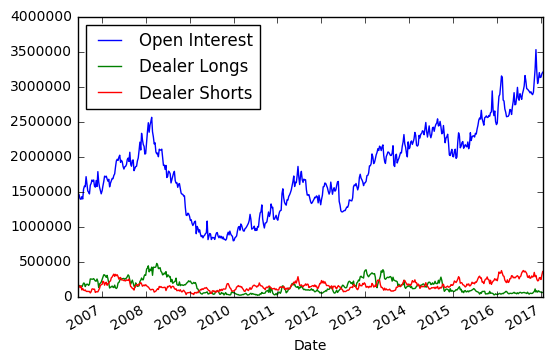

In [5]:
com.plot()

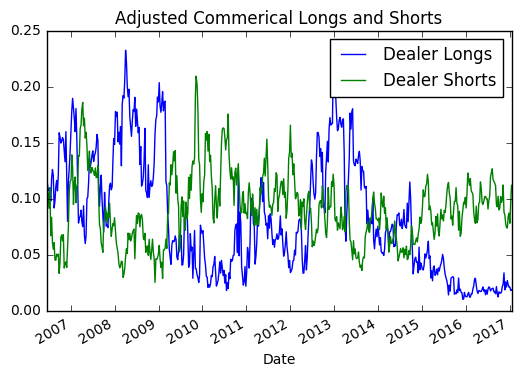

In [6]:
# adj = com[['Dealer Longs', 'Dealer Shorts']] / com['Open Interest']
adj = com.div(com['Open Interest'], axis='index').drop('Open Interest', 1)
adj.plot(title='Adjusted Commerical Longs and Shorts')

Date
2006-06-13   -0.010234
dtype: float64


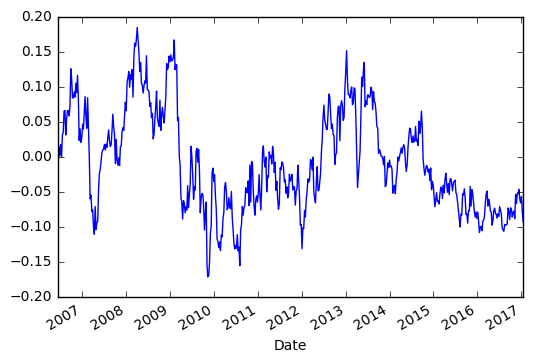

In [7]:
adj_net = (com['Dealer Longs'] - com['Dealer Shorts']) / com['Open Interest']
print(adj_net.head(1))
adj_net.plot()

In [8]:
def cot(df):
    max = df.max()
    min = df.min()
    current = df[len(df) -1]
    
    return (current - min) / (max - min)

In [9]:
com_index = adj_net.rolling(window=26, min_periods=26).apply(func=cot)

In [10]:
producer_index = adj['Dealer Shorts'].rolling(window=26, min_periods=26).apply(func=cot)

In [11]:
consumer_index = adj['Dealer Longs'].rolling(window=26, min_periods=26).apply(func=cot)

In [12]:
mu = adj_net.mean()
mu

-0.008084933986470812

In [13]:
sigma = adj_net.std()
sigma

0.07104747517353989

In [14]:
u_limit = mu + (2 * sigma)
u_limit

0.13401001636060897

In [15]:
l_limit = mu - (2 * sigma)
l_limit

-0.15017988433355059

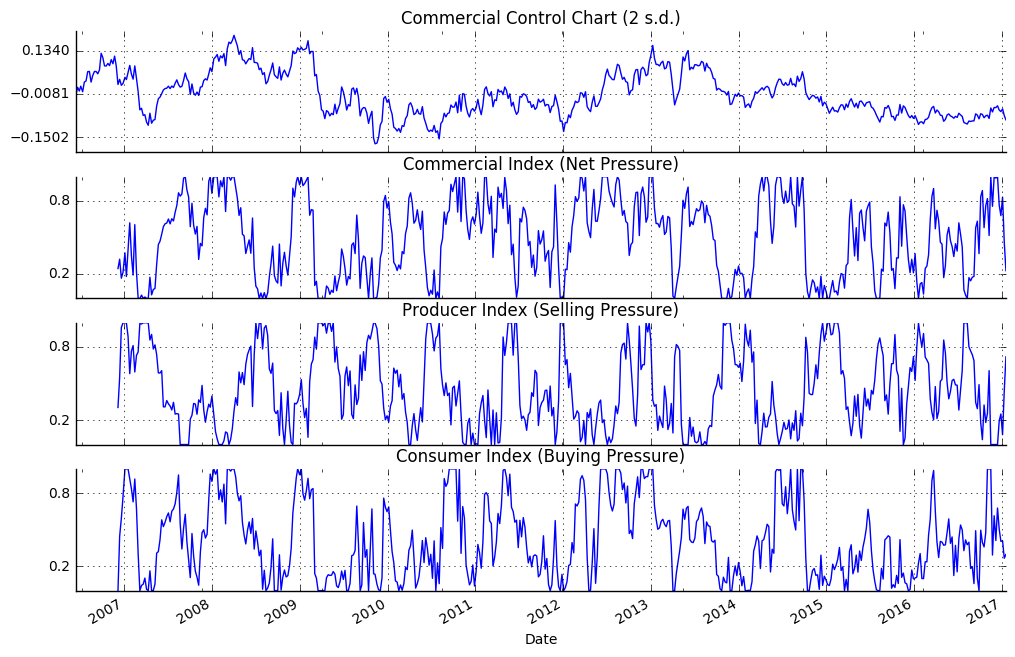

In [16]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(12,8), sharex=True)

adj_net.plot(color='blue',
          grid=True,
          linewidth=1,
          yticks=[u_limit, mu, l_limit],
          title='Commercial Control Chart (2 s.d.)',
          ax=ax[0])

com_index.plot(color='blue',
               grid=True,
               linewidth=1,
               yticks=[0.2, 0.8],
               title='Commercial Index (Net Pressure)',
               ax=ax[1])

producer_index.plot(color='blue',
               grid=True,
               linewidth=1,
               yticks=[0.2, 0.8],
               title='Producer Index (Selling Pressure)',
               ax=ax[2])

consumer_index.plot(color='blue',
               grid=True,
               linewidth=1,
               yticks=[0.2, 0.8],
               title='Consumer Index (Buying Pressure)',
               ax=ax[3])

for i in range(len(ax)):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].legend().set_visible(False)

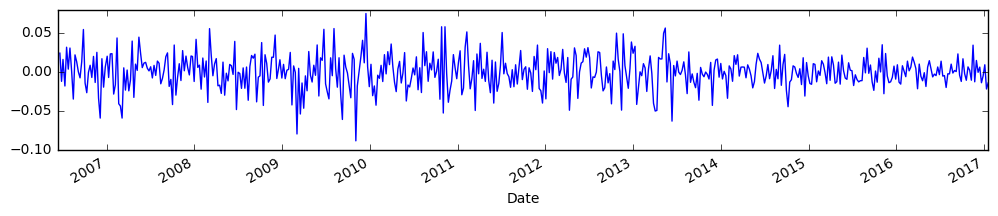

In [17]:
diff = adj_net.diff()
diff.plot(figsize=(12,2))

In [18]:
from pymc3 import Exponential, StudentT, Deterministic, Model
from pymc3.math import exp
from pymc3.distributions.timeseries import GaussianRandomWalk

with Model() as sp500_model:
    nu = Exponential('nu', 1./10, testval=5.)
    sigma = Exponential('sigma', 1./.02, testval=.1)
    s = GaussianRandomWalk('s', sigma**-2, shape=len(diff))
    volatility_process = Deterministic('volatility_process', exp(-2*s))
    r = StudentT('r', nu, lam=1/volatility_process, observed=diff)

ImportError: No module named 'pymc3'

In [ ]:
from pymc3 import variational

import scipy
with sp500_model:
    mu, sds, elbo = variational.advi(n=100000)
    step = NUTS(scaling=sp500_model.dict_to_array(sds)**2, is_cov=True)

    trace = sample(2000, step, start=mu, progressbar=True)

In [ ]:
traceplot(trace[200:], [nu, sigma]);

In [ ]:
import quandl.version as v

In [ ]:
quandl.version.VERSION